In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
from sklearn import neighbors




In [2]:
def img_load(fname):
    img = Image.open(fname)
    img = np.array(img)

    return img

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    input_image = tf.cast(image, tf.float32)

    return input_image

def resize(input_image, size):
        output_image = tf.image.resize(input_image, [size, size],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return output_image
    
def normalize(input_image):
        output_image = (input_image / 127.5) - 1

        return output_image    
    
def img_to_lut(input_image, target_image):

    Target = target_image*0.5+0.5
    Input  = input_image*0.5+0.5

    safe = Target
    x = 0
    tR = []
    tG = []
    tB = []
    shape = Target.shape
    icolor = []
    dist = []
    #differences on each pixel; here all pixels of the ixj array get sorted along 
    #one dimension (i*j long) for both the input and the target image in the same 
    #way. Afterwards for every color channel (tR, tG, TB) a list is created that 
    #contains the difference between target value and input value.
    for i in range(shape[0]):
        for j in range(shape[1]):
           
            tR.append(Target[i,j,0]-Input[i,j,0]) 
            tG.append(Target[i,j,1]-Input[i,j,1]) 
            tB.append(Target[i,j,2]-Input[i,j,2]) 
            #here a list is created that sorts the input RGB Values along the pixel numbers
            #in the same order as above. So it starts with the first line on the left, once
            #the line is finished, counting continues on the next line left
            icolor.append(Input[i,j,:]) 
     

    icolor = np.asarray(icolor)  

    interpolation = neighbors.KNeighborsRegressor(4, weights='distance')

    LUT_size = 32
    a = LUT_size - 1
    #here the input LUT is created out of equally spaced RGB values in R^3
    LUT = []
    for k in range(LUT_size):
        for j in range(LUT_size):
            for i in range(LUT_size):
                LUT.append([i/a,j/a, k/a])

    #since we have all lists in the same order (icolor and the color differences tR,
    # tG, tB) we now can fit a function between icolor and the coresponding color
    #difference at each RGB coordinate. Afterwrds we predict the difference of the 
    #LUT that is on a grit at this position

    interpolation = neighbors.KNeighborsRegressor(4, weights='distance')
    LUT = np.asarray(LUT) 
    tRp = interpolation.fit(icolor, tR).predict(LUT)
    tGp = interpolation.fit(icolor, tG).predict(LUT)
    tBp = interpolation.fit(icolor, tB).predict(LUT)
    
    for i in range(LUT_size**3):
        LUT[i,0] = LUT[i,0] + tRp[i]
        LUT[i,1] = LUT[i,1] + tGp[i]
        LUT[i,2] = LUT[i,2] + tBp[i]

    LUT = LUT.clip(min=0)
    return LUT

def img_to_lut_adv(input_image, target_image, factor):

    Target = target_image*0.5+0.5
    Input  = input_image*0.5+0.5

    safe = Target
    x = 0
    tR = []
    tG = []
    tB = []
    shape = Target.shape
    icolor = []
    dist = []
    #differences on each pixel; here all pixels of the ixj array get sorted along 
    #one dimension (i*j long) for both the input and the target image in the same 
    #way. Afterwards for every color channel (tR, tG, TB) a list is created that 
    #contains the difference between target value and input value.
    for i in range(shape[0]):
        for j in range(shape[1]):
           
            tR.append(Target[i,j,0]-Input[i,j,0]) 
            tG.append(Target[i,j,1]-Input[i,j,1]) 
            tB.append(Target[i,j,2]-Input[i,j,2]) 
            vec = (tR[x],tG[x],tB[x])
            dist.append(np.linalg.norm(vec))
            x = x + 1
            #here a list is created that sorts the input RGB Values along the pixel numbers
            #in the same order as above. So it starts with the first line on the left, once
            #the line is finished, counting continues on the next line left
            icolor.append(Input[i,j,:]) 
     

    np_dist = np.asarray(dist)
    stddev = np.std(np_dist)
    mean = np.mean(dist)
    del_list = []
    print('dev: '+str(stddev))
    print('mean: '+str(mean))
    print('length: '+str(len(icolor)))
    x = 0
    while x < len(icolor):
        if dist[x] > (mean + factor * stddev):
                del icolor[x]
                del dist[x]
                del tR[x]
                del tG[x]
                del tB[x]
        else:
            x = x + 1         
    #for i in range(shape[0]):
       #for j in range(shape[1]):
           # icolor.append(Input[i,j,:]) 
    print('length: '+str(len(icolor)))
    icolor = np.asarray(icolor)  

    interpolation = neighbors.KNeighborsRegressor(4, weights='distance')

    LUT_size = 32
    a = LUT_size - 1
    #here the input LUT is created out of equally spaced RGB values in R^3
    LUT = []
    for k in range(LUT_size):
        for j in range(LUT_size):
            for i in range(LUT_size):
                LUT.append([i/a,j/a, k/a])

    #since we have all lists in the same order (icolor and the color differences tR,
    # tG, tB) we now can fit a function between icolor and the coresponding color
    #difference at each RGB coordinate. Afterwrds we predict the difference of the 
    #LUT that is on a grit at this position

    interpolation = neighbors.KNeighborsRegressor(4, weights='distance')
    LUT = np.asarray(LUT) 
    tRp = interpolation.fit(icolor, tR).predict(LUT)
    tGp = interpolation.fit(icolor, tG).predict(LUT)
    tBp = interpolation.fit(icolor, tB).predict(LUT)
    
    for i in range(LUT_size**3):
        LUT[i,0] = LUT[i,0] + tRp[i]
        LUT[i,1] = LUT[i,1] + tGp[i]
        LUT[i,2] = LUT[i,2] + tBp[i]

    LUT = LUT.clip(min=0)
    return LUT

In [3]:
tf.executing_eagerly()


True

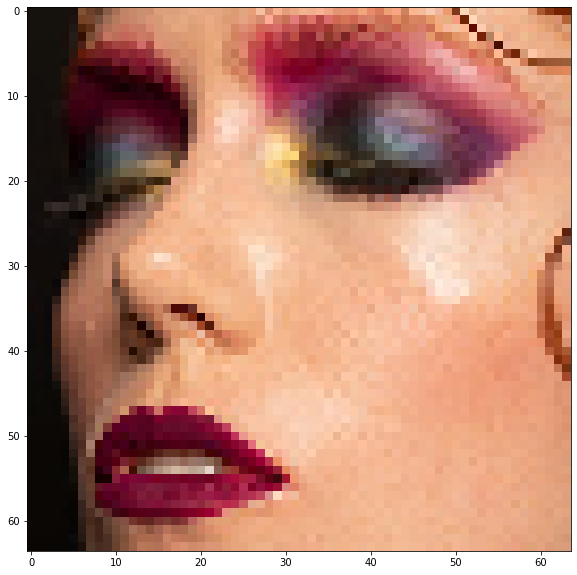

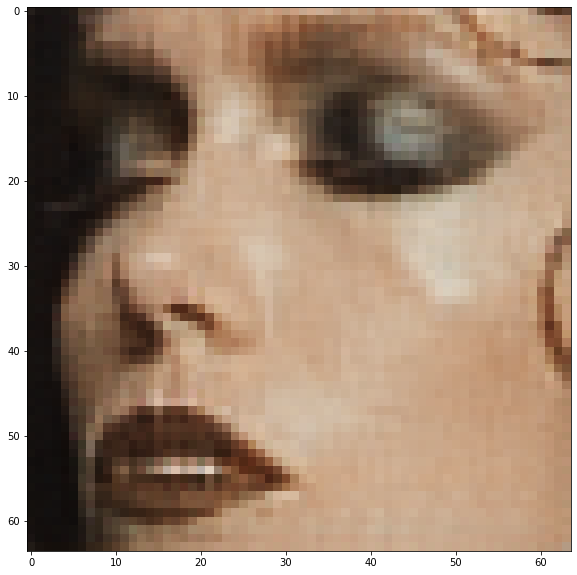

In [8]:
img_size = 64

advanced = False                                             # Here we need a checkbox in the Front end "advanced mode"
max_factor = 1.5                                             # Here we need a field to enter a float value "x simga"                          


model_path = ''                                             #location of the model
model_name = 'photo_2'
model_path = model_path + model_name


image_path = ''                                             #location of the image   
image_name = 'test_img.jpg'
image_path = image_path + image_name


input_image = load(image_path)                               #preprocess the image
input_image = resize(input_image,img_size)
input_image = normalize(input_image)
input_image = tf.reshape(input_image,[1,img_size,img_size,3])


generator = tf.keras.models.load_model(model_path)          # apply the model

target = generator(input_image, training=True)
plt.figure(figsize =(10,10))
plt.imshow(input_image[0]*0.5+0.5)
plt.show()



plt.figure(figsize =(10,10))
plt.imshow(target[0]*0.5+0.5)
plt.show()
 
if advanced == True:                                                       #create the LUT in advanced mode
    LUT = img_to_lut_adv(input_image[0], target[0], max_factor)
else:                                                                      #create the LUT in standard mode
    LUT = img_to_lut(input_image[0], target[0])

np.savetxt('test.cube',LUT,fmt="%2.4f", delimiter=" ")                     #save the file that should be downloaded